# Unet


[Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a deep learning model that can perform image segmenation. This notebook uses it for just two classes, but with small tweaks I think the model can be extended to multiple classes.

In [1]:
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import os

In [2]:
img = imread("data/input/img.tif")
label = imread("data/output/img.tif")

The training data is a single image of some cells.

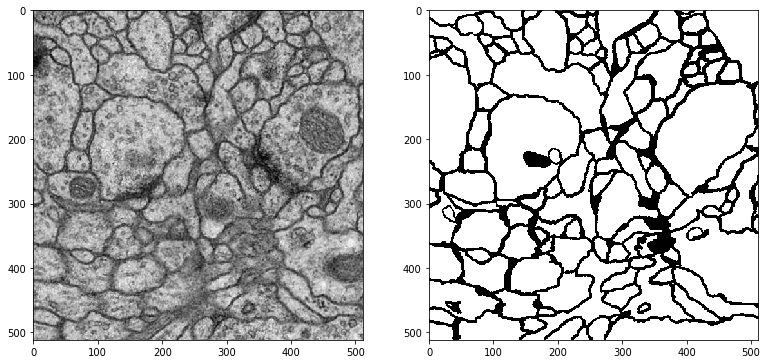

In [3]:
fig,ax = plt.subplots(1,2,figsize=(13,8))
ax[0].imshow(img,cmap="gray")
ax[1].imshow(label,cmap="gray");

# Data Augmentation

We need alot of data to train a deep learning model but, in this case the training datasets is pityfully small, just a single image. Thankfully we can get around this using image augmentation. This is the process of warping the image by applying transformations such as image rotations, shifts and rescaling in order to create new images which look similar.


In [4]:
import numpy as np
import Augmentor

In [5]:
img_dir = "data/input"
label_dir = "data/output"
#needs to be fully path, change to you correct path where you wanna create images
train_dir = "/home/dom/code/deep-learning/papers/unet/data/augmented/train" 
test_dir = "/home/dom/code/deep-learning/papers/unet/data/augmented/test" 

Since we need to apply the same augmentations to both images, they both must have the same name.


In [71]:
%%bash 
tree data

data
├── input
│   └── img.tif
└── output
    └── img.tif

2 directories, 2 files


In [75]:
#make train and test directories
os.makedirs(train_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

We will output the newly generated images to the augmented directory.

In [76]:
def build_pipeline(img_dir,ground_truth_dir,augmented_dir): 
    
    p = Augmentor.Pipeline(source_directory=img_dir,output_directory=augmented_dir)
    p.ground_truth(ground_truth_dir)
    p.set_seed(1)
    p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_top_bottom(probability=0.5)
    return p

In [77]:
p1 = build_pipeline(img_dir,label_dir,train_dir)
p2 = build_pipeline(img_dir,label_dir,test_dir)

Initialised with 1 image(s) found.
Output directory set to /home/dom/code/deep-learning/papers/unet/data/augmented/train.1 ground truth image(s) found.
Initialised with 1 image(s) found.
Output directory set to /home/dom/code/deep-learning/papers/unet/data/augmented/test.1 ground truth image(s) found.


In [78]:
#generate testing images
p1.sample(1000) 
p2.sample(50) 

Processing <PIL.Image.Image image mode=L size=512x512 at 0x7F5AF003EF28>: 100%|██████████| 1000/1000 [00:09<00:00, 108.59 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x7F5AB021C9B0>: 100%|██████████| 50/50 [00:00<00:00, 113.67 Samples/s]


The generated images can now be found in the augmented directory. Examples of the files names

```
'_groundtruth_(1)_input_img.tif_f7e44e74-3784-4aab-acb4-fff8c18f4308.tif'   input_original_img.tif_f7e44e74-3784-4aab-acb4-fff8c18f4308.tif
```


Lets create a pytorch dataset for these.

In [10]:
import os
from torch.utils.data import Dataset
import torch
import cv2
from  glob import glob

In [11]:
class ImageDataset(Dataset):
    def __init__(self, img_dir):
        super(ImageDataset,self).__init__()
        self.labels_path = glob(os.path.join(img_dir  ,"_groundtruth*"))
        self.imgs_path = glob(os.path.join(img_dir,"input*"))
        self.imgs_path.sort()
        self.labels_path.sort()
    
    def __len__(self):
        return len(self.imgs_path)
        
    def __getitem__(self,i):
        #read as greyscale and add channels first C x W x H
        x = np.expand_dims(cv2.imread(self.imgs_path[i],0),0) / 255
        x = torch.from_numpy(x.astype("float32"))
        y = np.expand_dims(cv2.imread(self.labels_path[i],0),0) > 125
        y = torch.from_numpy(y.astype("int64"))
        y = y.squeeze()
        return x,y 

In [12]:
dataset = ImageDataset(train_dir)

Plot a few of the images to make sure the augmentation worked well.

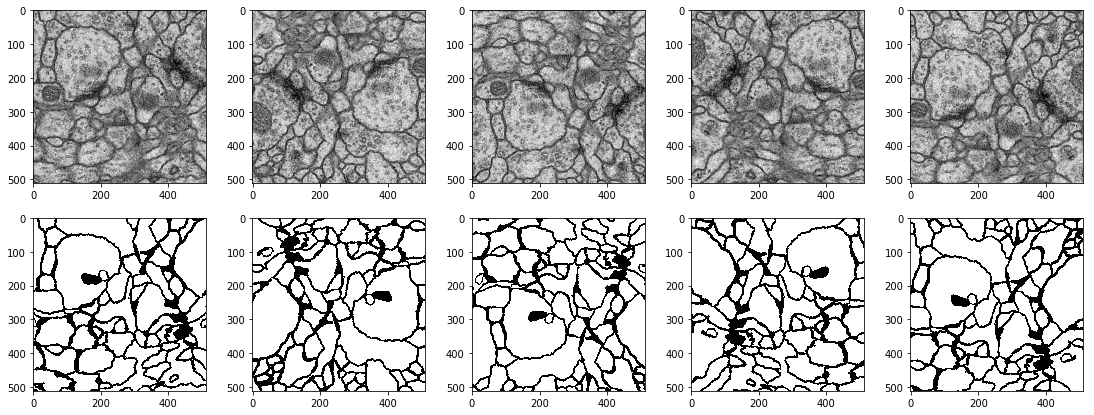

In [13]:
fig,axes = plt.subplots(2,5,figsize=(19,7))

for i in range(5):
    x,y = dataset[i]
    axes[0][i].imshow(torch.squeeze(x),cmap="gray")
    axes[1][i].imshow(torch.squeeze(y),cmap="gray")

# Model

The model architecture looks like this.

![img](img/unet-arch.png)

My implementation isn't completely true to the picture since it adds padding to the down convlutions.

In [14]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

In [15]:
class DoubleConv(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.layers = nn.Sequential(
            #padding not true to og implementation
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        return self.layers(x)

In [16]:
class Down(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(Down,self).__init__()
        self.conv = DoubleConv(in_channels,out_channels)
        self.down = nn.MaxPool2d(2)
    
    def forward(self,x):
        x1 = self.conv(x)
        x2 = self.down(x1)
        return x1,x2
        

In [17]:
class Up(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(Up,self).__init__()
        self.up = nn.ConvTranspose2d(in_channels,out_channels,2,stride=2)
        self.conv =  DoubleConv(in_channels,out_channels)
        
    def forward(self,x1,x2):
        x1 = self.up(x1)
        #add relu
        
        #add some form of padding for odd tensors
        o = torch.cat([x2, x1], dim=1)
        o = self.conv(o)
        return o
        

In [18]:
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        #down
        self.d1 = Down(1,64)
        self.d2 = Down(64,128)
        self.d3 = Down(128,256)
        self.d4 = Down(256,512)
        #across
        self.a1 = DoubleConv(512,1024)
        #up!
        self.u1 = Up(1024,512)
        self.u2 = Up(512,256)
        self.u3 = Up(256,128)
        self.u4 = Up(128,64)
        self.out = nn.Conv2d(64,2,3,padding=1)
    
    def forward(self,x):
        x1,o = self.d1(x)
        x2,o = self.d2(o)
        x3,o = self.d3(o)
        x4,o = self.d4(o)
        o = self.a1(o)
        o = self.u1(o,x4)
        o = self.u2(o,x3)
        o = self.u3(o,x2)
        o = self.u4(o,x1)
        o = self.out(o)
        return o

# Training

In [19]:
from tqdm import tqdm

In [20]:
train_dataset = ImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=4)


In [21]:
#https://github.com/pytorch/pytorch/issues/6098
# DEIVCE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"
DEVICE = "cuda:0"

In [22]:
model = Unet()
model = model.cuda()

In [23]:
opt = optim.Adam(model.parameters())

In [24]:
def train(model, opt, dataloader):
    model.train()
    total_loss = 0
    for batch_idx, (x,y) in enumerate(tqdm(train_loader)):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        opt.zero_grad()
        y_pred = model(x)
        loss = F.cross_entropy(y_pred,y)
        total_loss += loss.data
        loss.backward()
        opt.step()
        
    return total_loss

In [25]:
epochs = 5
for _ in range(epochs):
    train(model,opt,train_loader)

100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


# Testing

In [26]:
test_dataset = ImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=4)

In [27]:
#test it on first image
x,y = next(iter(test_loader))
y_pred = model(x.cuda())

In [80]:
img_pred = torch.argmax(y_pred,dim=1).squeeze()

Text(0.5,1,'OG Image')

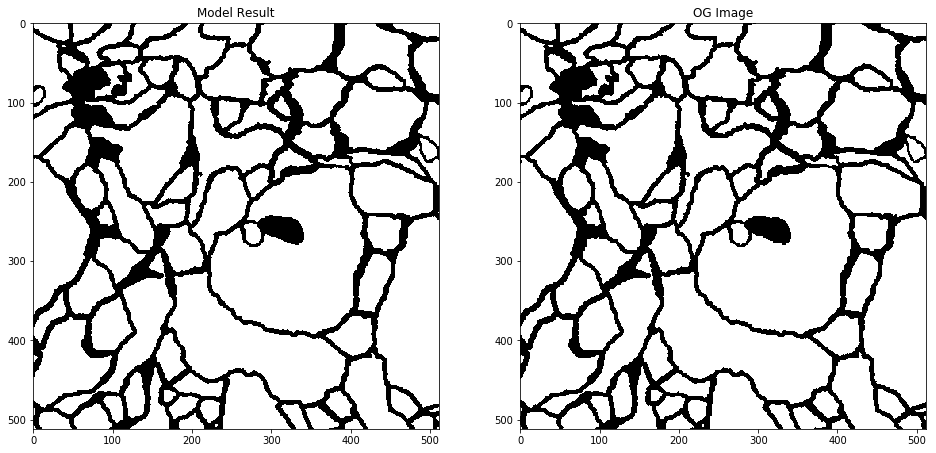

In [81]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(img_pred,cmap="gray")
axes[0].set_title("Model Result")
axes[1].imshow(y.squeeze(),cmap="gray")
axes[1].set_title("OG Image")

In [95]:
#need to test more throughly
np.mean(y.squeeze().data.numpy() == img_pred.squeeze().cpu().data.numpy())

0.9888076782226562